<a href="https://colab.research.google.com/github/pucuk-yusup/Portofolio-Analisis/blob/main/Simulasi_Equity_Stock_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================================================
# BI Rate Hold Simulation — Sector Impact (Equity Lens)
# Author: Yusup Nurfaizi
# Note: Illustrative model for learning; not investment advice
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# 1) PARAMETER GLOBAL & SKENARIO
# -----------------------------
np.random.seed(42)

scenarios = {
    # delta_policy_rate (bps), fx_vol (annualized, proxy), liquidity_incentive (% DPK max), credit_incentive_forward_looking(True/False)
    "HOLD_Base":      {"dBI_bps": 0,   "fx_vol": 0.12, "liq_incentive": 0.005, "fwd_credit": True},
    "CUT_25bps":      {"dBI_bps": -25, "fx_vol": 0.11, "liq_incentive": 0.005, "fwd_credit": True},
    "STRESS_FX":      {"dBI_bps": 0,   "fx_vol": 0.18, "liq_incentive": 0.003, "fwd_credit": False},
    "EASING_Later":   {"dBI_bps": -25, "fx_vol": 0.13, "liq_incentive": 0.005, "fwd_credit": True},
}

In [3]:
# Suku bunga baseline (ilustratif)
baseline = {
    "BI_rate": 4.75,  # %
    "lending_rate_bank": 9.05,  # %
    "dpk_rate_bank": 4.52,      # %
    "mortgage_rate": 9.50,      # % rata-rata KPR
}

In [4]:
# Ticker sampel per sektor (ganti sesuai preferensi)
banks = ["BBCA","BBRI","BMRI"]
property_names = ["PWON","SMRA","CTRA"]
consumer = ["ICBP","MYOR"]

In [5]:
# Baseline fundamental (hipotetik)
fundamentals = {
    "BBCA": {"EPS": 100, "PE": 25, "CASA": 0.79, "COF": baseline["dpk_rate_bank"]},
    "BBRI": {"EPS": 100, "PE": 12, "CASA": 0.65, "COF": baseline["dpk_rate_bank"]+0.2},
    "BMRI": {"EPS": 100, "PE": 12, "CASA": 0.70, "COF": baseline["dpk_rate_bank"]+0.1},
    "PWON": {"EPS": 100, "PE": 10, "DebtCost": 9.2, "PreSales_sens": 0.6},
    "SMRA": {"EPS": 100, "PE": 14, "DebtCost": 9.6, "PreSales_sens": 0.7},
    "CTRA": {"EPS": 100, "PE": 12, "DebtCost": 9.4, "PreSales_sens": 0.65},
    "ICBP": {"EPS": 100, "PE": 18, "FX_input_share": 0.35},
    "MYOR": {"EPS": 100, "PE": 22, "FX_input_share": 0.40},
}

In [6]:
# Elastisitas & koefisien transmisi (ilustratif)
params = {
    "deposit_beta": 0.35,  # seberapa cepat DPK rate mengikuti BI rate
    "loan_beta":    0.25,  # seberapa cepat lending rate mengikuti BI rate
    "nim_sensitivity_to_spread": 0.6,  # NIM bereaksi pada (lending - dpk)

    "credit_growth_base": 0.08,         # 8% yoy baseline
    "credit_growth_per_incentive": 0.10, # tambahan elastisitas jika bank eligible (skala dikalikan liq_incentive)

    "property_demand_sens_rate": -0.20, # -20% permintaan per +100bps mortgage
    "property_presales_base": 0.05,     # 5% yoy baseline

    "consumer_fx_cost_sens": 0.50,      # proporsi dampak FX ke COGS (skala oleh FX_input_share)
    "consumer_revenue_base": 0.07,      # 7% yoy revenue baseline
}

In [7]:
# Valuasi: PE rerating per skenario (ilustratif, cerminkan risk-on/off)
pe_rerate = {
    "HOLD_Base":    {"banks": +0.5, "property": -0.3, "consumer": +0.2},
    "CUT_25bps":    {"banks": +0.8, "property": +0.7, "consumer": +0.3},
    "STRESS_FX":    {"banks": -0.5, "property": -0.8, "consumer": -0.2},
    "EASING_Later": {"banks": +0.6, "property": +0.2, "consumer": +0.2},
}

In [15]:
# --------------------------------
# 2) FUNGSI UTILITAS & SIMULASI
# --------------------------------
def simulate_bank(ticker, scen):
    f = fundamentals[ticker]
    # Hitung perubahan lending & dpk rate dari BI move
    dpk_rate = baseline["dpk_rate_bank"] + params["deposit_beta"] * (scen["dBI_bps"] / 100.0)
    lend_rate = baseline["lending_rate_bank"] + params["loan_beta"] * (scen["dBI_bps"] / 100.0)

    # Spread & dampaknya pada NIM
    spread = max(lend_rate - dpk_rate, 0.1)
    spread_base = baseline["lending_rate_bank"] - baseline["dpk_rate_bank"]
    d_spread = spread - spread_base
    nim_effect = params["nim_sensitivity_to_spread"] * d_spread / 100.0  # ke % poin NIM ~ proxy EPS

    # Kredit growth: base + elastisitas karena insentif likuiditas
    add_growth = params["credit_growth_per_incentive"] * scen["liq_incentive"] if scen["fwd_credit"] else 0.0
    credit_growth = params["credit_growth_base"] + add_growth

    # EPS Growth proxy: kombinasi NIM effect + leverage dari volume
    eps_growth = 0.50*nim_effect + 0.50*credit_growth  # bobot ilustratif

    # Risiko provisi saat FX volatile (stress menekan EPS)
    risk_hit = -0.10 * max(scen["fx_vol"] - 0.13, 0)  # jika vol > 13%, ada hit
    eps_growth_adj = eps_growth + risk_hit

    # Valuasi: P/E re-rating
    sector = "banks"
    PE_new = max(f["PE"] * (1 + pe_rerate[current_scenario][sector]/100.0), 5)
    EPS_new = f["EPS"] * (1 + eps_growth_adj)

    price_change = (PE_new * EPS_new) / (f["PE"] * f["EPS"]) - 1
    return {
        "Ticker": ticker,
        "Sector": "Banking",
        "EPS_growth": eps_growth_adj,
        "PE_new": PE_new,
        "Price_return": price_change
    }

def simulate_property(ticker, scen):
    f = fundamentals[ticker]
    # Mortgage rate turun bila BI cut; hold -> kurang dorongan
    mortgage_rate = baseline["mortgage_rate"] + params["loan_beta"] * (scen["dBI_bps"] / 100.0)
    d_mortgage = mortgage_rate - baseline["mortgage_rate"]

    # Permintaan (pre-sales) sensitif pada rate
    presales_growth = params["property_presales_base"] + params["property_demand_sens_rate"] * (d_mortgage)
    # EPS kira-kira mengikuti presales sensitivitas (dikalikan profil emiten)
    eps_growth = presales_growth * fundamentals[ticker]["PreSales_sens"]

    # FX vol tinggi bisa naikkan beban bunga/biaya material impor
    risk_hit = -0.05 * max(scen["fx_vol"] - 0.13, 0)
    eps_growth_adj = eps_growth + risk_hit

    sector = "property"
    PE_new = max(f["PE"] * (1 + pe_rerate[current_scenario][sector]/100.0), 4)
    EPS_new = f["EPS"] * (1 + eps_growth_adj)

    price_change = (PE_new * EPS_new) / (f["PE"] * f["EPS"]) - 1
    return {
        "Ticker": ticker,
        "Sector": "Property",
        "EPS_growth": eps_growth_adj,
        "PE_new": PE_new,
        "Price_return": price_change
    }

def simulate_consumer(ticker, scen):
    f = fundamentals[ticker]
    # Revenue growth baseline, margin sensitif terhadap biaya impor vs FX vol
    revenue_growth = params["consumer_revenue_base"]

    # Jika FX volatil tinggi, biaya bahan impor (FX_input_share) meningkat → tekan margin → tekan EPS
    fx_cost_pressure = params["consumer_fx_cost_sens"] * f["FX_input_share"] * max(scen["fx_vol"] - 0.13, 0)
    eps_growth = revenue_growth - fx_cost_pressure

    sector = "consumer"
    PE_new = max(f["PE"] * (1 + pe_rerate[current_scenario][sector]/100.0), 6)
    EPS_new = f["EPS"] * (1 + eps_growth)

    price_change = (PE_new * EPS_new) / (f["PE"] * f["EPS"]) - 1
    return {
        "Ticker": ticker,
        "Sector": "Consumer",
        "EPS_growth": eps_growth,
        "PE_new": PE_new,
        "Price_return": price_change
    }

In [16]:
# --------------------------------
# 3) JALANKAN SIMULASI SEMUA SKENARIO
# --------------------------------
all_results = {}
for current_scenario, scen in scenarios.items():
    rows = []
    for t in banks:
        rows.append(simulate_bank(t, scen))
    for t in property_names:
        rows.append(simulate_property(t, scen))
    for t in consumer:
        rows.append(simulate_consumer(t, scen))
    df = pd.DataFrame(rows)
    all_results[current_scenario] = df.sort_values(["Sector","Ticker"]).reset_index(drop=True)

=== Summary (EPS Growth & Price Return, mean) ===


,Scenario,Sector,Mean_EPS_g,Mean_Return
0,HOLD_Base,Banking,0.040250,0.045451
1,HOLD_Base,Consumer,0.070000,0.072140
2,HOLD_Base,Property,0.032500,0.029402
3,CUT_25bps,Banking,0.040325,0.048648
4,CUT_25bps,Consumer,0.070000,0.073210
5,CUT_25bps,Property,0.040625,0.047909
6,STRESS_FX,Banking,0.035000,0.029825
7,STRESS_FX,Consumer,0.060625,0.058504
8,STRESS_FX,Property,0.030000,0.021760
9,EASING_Later,Banking,0.040325,0.046567


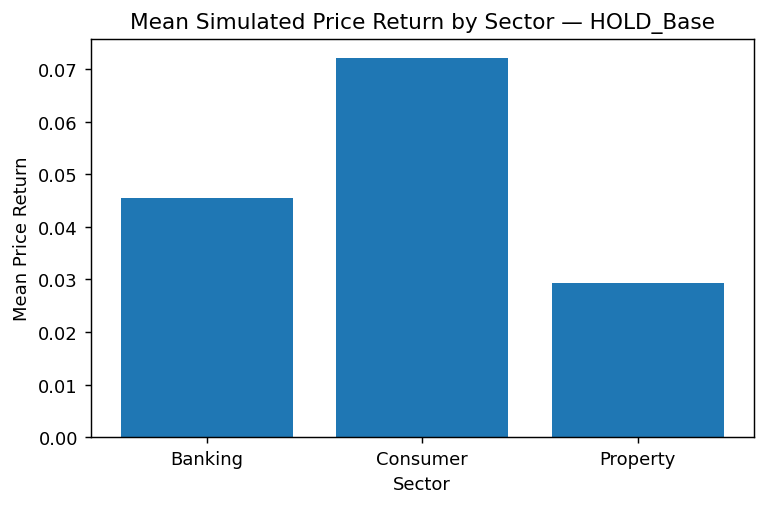

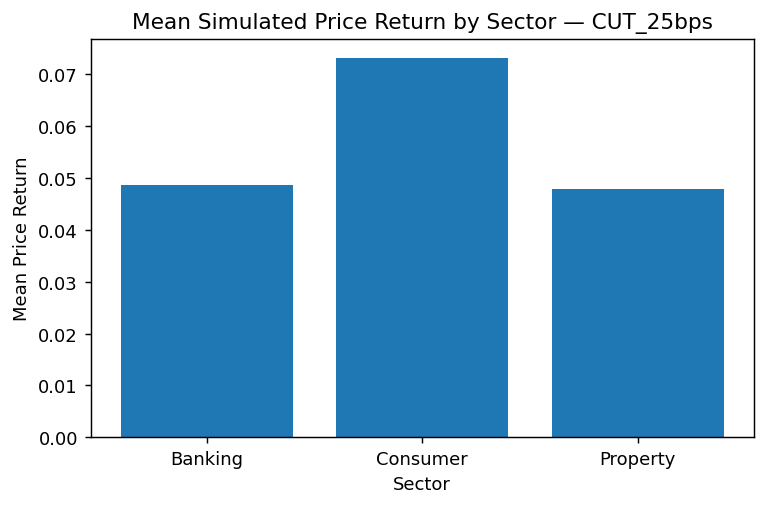

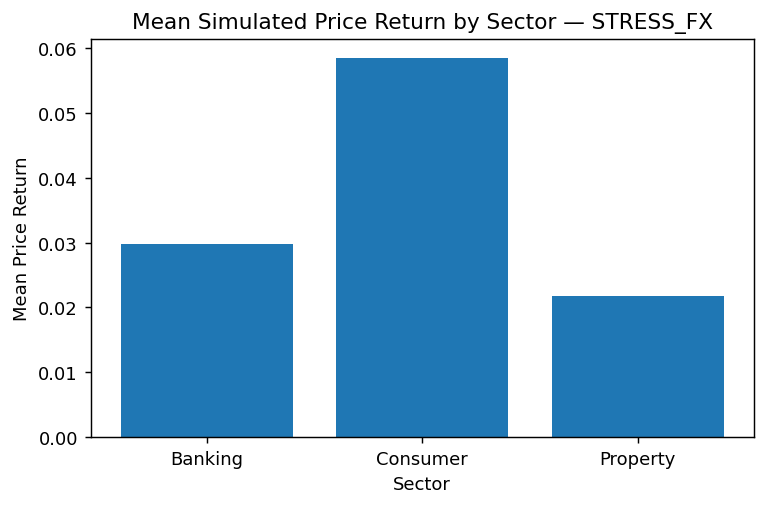

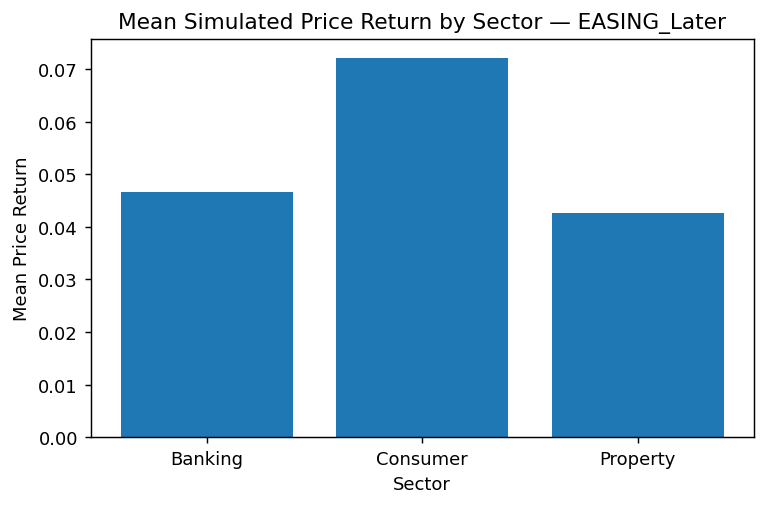


=== Top Picks by Scenario ===


,Scenario,Ticker,Sector,EPS_growth,PE_new,Price_return
0,HOLD_Base,ICBP,Consumer,0.070000,18.036,0.072140
1,HOLD_Base,MYOR,Consumer,0.070000,22.044,0.072140
2,HOLD_Base,BMRI,Banking,0.040250,12.060,0.045451
3,HOLD_Base,BBRI,Banking,0.040250,12.060,0.045451
4,HOLD_Base,BBCA,Banking,0.040250,25.125,0.045451
5,CUT_25bps,MYOR,Consumer,0.070000,22.066,0.073210
6,CUT_25bps,ICBP,Consumer,0.070000,18.054,0.073210
7,CUT_25bps,SMRA,Property,0.043750,14.098,0.051056
8,CUT_25bps,BBRI,Banking,0.040325,12.096,0.048648
9,CUT_25bps,BMRI,Banking,0.040325,12.096,0.048648


In [17]:
# --------------------------------
# 4) TABEL RINGKAS & VISUAL
# --------------------------------
def summarize(df):
    return df.groupby("Sector").agg(
        Mean_EPS_g=("EPS_growth","mean"),
        Mean_Return=("Price_return","mean")
    ).reset_index()

summary_panels = []
for scen_name, df in all_results.items():
    s = summarize(df)
    s.insert(0,"Scenario", scen_name)
    summary_panels.append(s)

summary = pd.concat(summary_panels, ignore_index=True)

# Tampilkan tabel ringkas
print("=== Summary (EPS Growth & Price Return, mean) ===")
display(summary)

# Plot per skenario: rata-rata return per sektor
for scen_name, df in all_results.items():
    agg = df.groupby("Sector")["Price_return"].mean().reset_index()
    plt.figure(figsize=(6,4), dpi=130)
    plt.bar(agg["Sector"], agg["Price_return"])
    plt.title(f"Mean Simulated Price Return by Sector — {scen_name}")
    plt.xlabel("Sector")
    plt.ylabel("Mean Price Return")
    plt.tight_layout()
    plt.show()

# Top picks per skenario (berdasarkan return)
tops = []
for scen_name, df in all_results.items():
    top = df.sort_values("Price_return", ascending=False).head(5).copy()
    top.insert(0,"Scenario", scen_name)
    tops.append(top)
top_picks = pd.concat(tops, ignore_index=True)
print("\n=== Top Picks by Scenario ===")
display(top_picks[["Scenario","Ticker","Sector","EPS_growth","PE_new","Price_return"]])

=== Summary (EPS Growth & Price Return, mean) ===


,Scenario,Sector,Mean_EPS_g,Mean_Return
0,HOLD_Base,Banking,0.040250,0.045451
1,HOLD_Base,Consumer,0.070000,0.072140
2,HOLD_Base,Property,0.032500,0.029402
3,CUT_25bps,Banking,0.040325,0.048648
4,CUT_25bps,Consumer,0.070000,0.073210
5,CUT_25bps,Property,0.040625,0.047909
6,STRESS_FX,Banking,0.035000,0.029825
7,STRESS_FX,Consumer,0.060625,0.058504
8,STRESS_FX,Property,0.030000,0.021760
9,EASING_Later,Banking,0.040325,0.046567


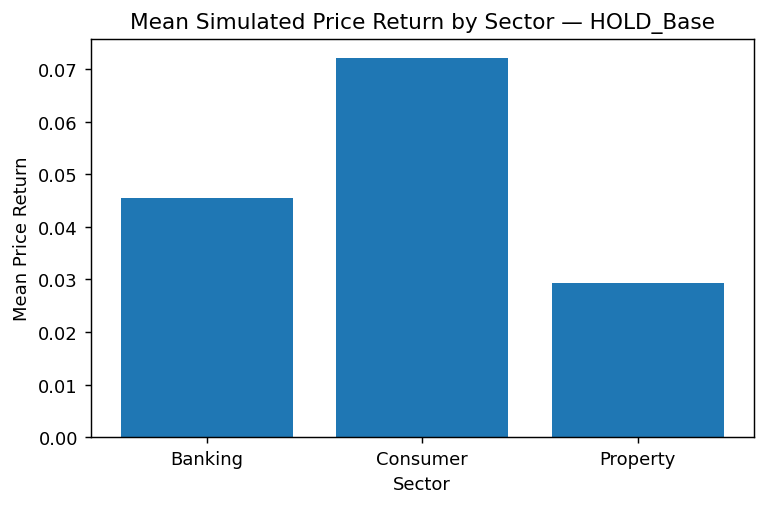

✅ Grafik 'Mean_Price_Return_HOLD_Base.png' berhasil disimpan.


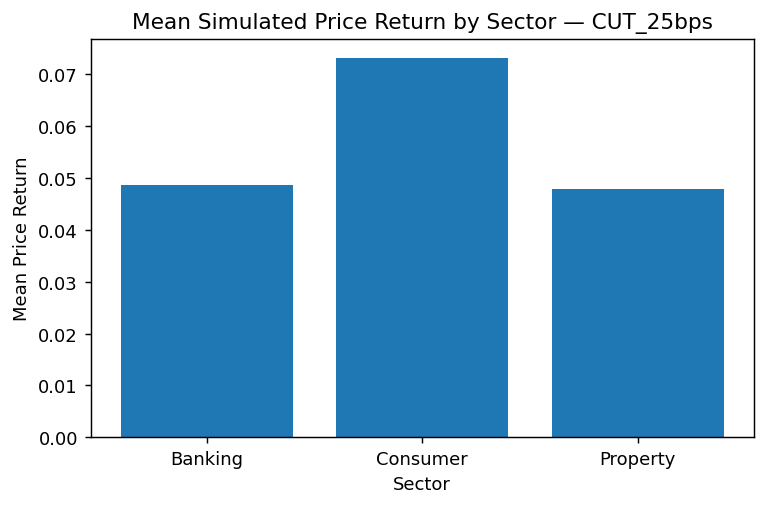

✅ Grafik 'Mean_Price_Return_CUT_25bps.png' berhasil disimpan.


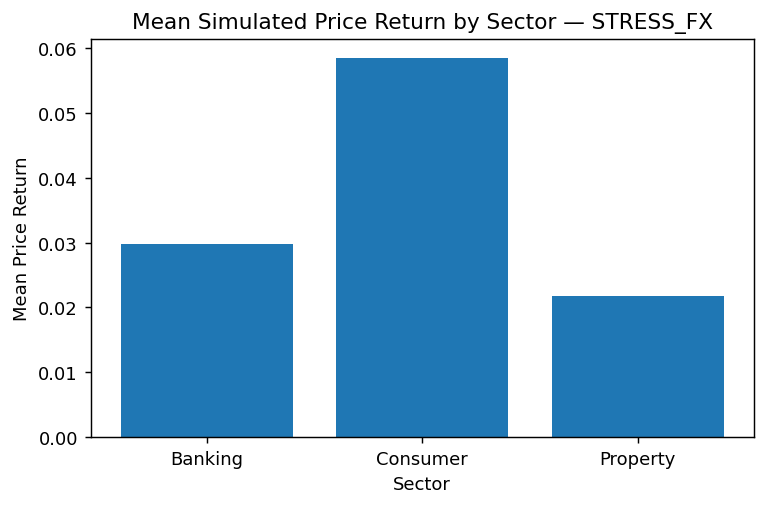

✅ Grafik 'Mean_Price_Return_STRESS_FX.png' berhasil disimpan.


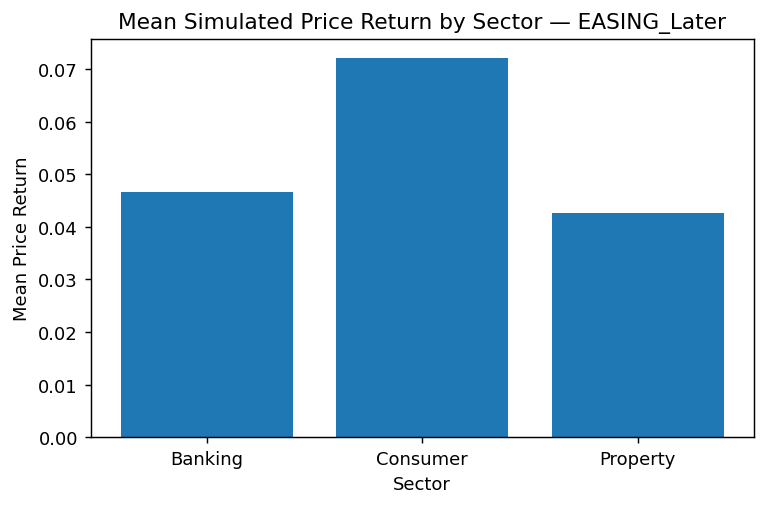

✅ Grafik 'Mean_Price_Return_EASING_Later.png' berhasil disimpan.

=== Top Picks by Scenario ===


,Scenario,Ticker,Sector,EPS_growth,PE_new,Price_return
0,HOLD_Base,ICBP,Consumer,0.070000,18.036,0.072140
1,HOLD_Base,MYOR,Consumer,0.070000,22.044,0.072140
2,HOLD_Base,BMRI,Banking,0.040250,12.060,0.045451
3,HOLD_Base,BBRI,Banking,0.040250,12.060,0.045451
4,HOLD_Base,BBCA,Banking,0.040250,25.125,0.045451
5,CUT_25bps,MYOR,Consumer,0.070000,22.066,0.073210
6,CUT_25bps,ICBP,Consumer,0.070000,18.054,0.073210
7,CUT_25bps,SMRA,Property,0.043750,14.098,0.051056
8,CUT_25bps,BBRI,Banking,0.040325,12.096,0.048648
9,CUT_25bps,BMRI,Banking,0.040325,12.096,0.048648


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# --------------------------------
# 4) TABEL RINGKAS & VISUAL (SAVEFIG Version)
# --------------------------------
def summarize(df):
    return df.groupby("Sector").agg(
        Mean_EPS_g=("EPS_growth", "mean"),
        Mean_Return=("Price_return", "mean")
    ).reset_index()

summary_panels = []
for scen_name, df in all_results.items():
    s = summarize(df)
    s.insert(0, "Scenario", scen_name)
    summary_panels.append(s)

summary = pd.concat(summary_panels, ignore_index=True)

# === 4.1 Tampilkan tabel ringkas ===
print("=== Summary (EPS Growth & Price Return, mean) ===")
display(summary)

# === 4.2 Plot per skenario & simpan hasil ===
import os
from google.colab import files

for scen_name, df in all_results.items():
    agg = df.groupby("Sector")["Price_return"].mean().reset_index()

    plt.figure(figsize=(6, 4), dpi=130)
    plt.bar(agg["Sector"], agg["Price_return"])
    plt.title(f"Mean Simulated Price Return by Sector — {scen_name}")
    plt.xlabel("Sector")
    plt.ylabel("Mean Price Return")
    plt.tight_layout()

    # Simpan gambar sebelum ditampilkan
    filename = f"Mean_Price_Return_{scen_name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()

    print(f"✅ Grafik '{filename}' berhasil disimpan.")

# === 4.3 Top picks per skenario ===
tops = []
for scen_name, df in all_results.items():
    top = df.sort_values("Price_return", ascending=False).head(5).copy()
    top.insert(0, "Scenario", scen_name)
    tops.append(top)

top_picks = pd.concat(tops, ignore_index=True)
print("\n=== Top Picks by Scenario ===")
display(top_picks[["Scenario", "Ticker", "Sector", "EPS_growth", "PE_new", "Price_return"]])

# === 4.4 Unduh salah satu file contoh ===
# Ganti nama file sesuai skenario yang kamu mau unduh (misal "HOLD_Base")
files.download("Mean_Price_Return_HOLD_Base.png")

In [18]:
# --------------------------------
# 5) CATATAN UNTUK NARASI (print-out)
# --------------------------------
notes = f"""
NARASI ANALIS (contoh poin bicara):
1) 'Hold' menjaga stabilitas → FX vol jadi jangkar utama sentimen sektor.
2) Banking diuntungkan medium-term: insentif likuiditas + kredit forward-looking → volume tumbuh, NIM tidak terlalu tergerus bila DPK normalisasi bertahap.
3) Property lebih sensitif pada mortgage rate; tanpa cut signifikan, permintaan cenderung menunggu (pre-sales risk).
4) Consumer staples relatif defensif; sensitivitas pada volatilitas FX tetap perlu dipantau.
5) Per sektor, gunakan kombinasi EPS growth proxy + re-rating PE untuk memetakan risk/return.
6) Ini model ilustratif — ganti asumsi: loan_beta, deposit_beta, liq_incentive, dan pe_rerate sesuai riset.
"""
print(notes)


NARASI ANALIS (contoh poin bicara):
1) 'Hold' menjaga stabilitas → FX vol jadi jangkar utama sentimen sektor.
2) Banking diuntungkan medium-term: insentif likuiditas + kredit forward-looking → volume tumbuh, NIM tidak terlalu tergerus bila DPK normalisasi bertahap.
3) Property lebih sensitif pada mortgage rate; tanpa cut signifikan, permintaan cenderung menunggu (pre-sales risk).
4) Consumer staples relatif defensif; sensitivitas pada volatilitas FX tetap perlu dipantau.
5) Per sektor, gunakan kombinasi EPS growth proxy + re-rating PE untuk memetakan risk/return.
6) Ini model ilustratif — ganti asumsi: loan_beta, deposit_beta, liq_incentive, dan pe_rerate sesuai riset.

